In [4]:
import chardet
from glob import glob
from os.path import join, dirname
import datetime, time
import os, sys
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler, MinMaxScaler
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, SimpleRNN, LSTM, GRU, Reshape, RepeatVector, MaxPooling2D, Dropout, Bidirectional, Attention, BatchNormalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import model_to_dot
import imblearn
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import random
pd.set_option('display.max_columns', None)

print('Python Version : \n 3.7')
print(f'Tensorflow Version : \n {tf.__version__}')
print('-------------------------------------')
print('GPU : \n GeForce RTX 2060')
# device_lib.list_local_devices()[2]
print('-------------------------------------')
print('CUDA Version :\n 10.1')
# !nvcc -V

Python Version : 
 3.7
Tensorflow Version : 
 2.3.0
-------------------------------------
GPU : 
 GeForce RTX 2060
-------------------------------------
CUDA Version :
 10.1


In [5]:
#######################
# Global Parameter
####################
num_classes = 7                           # {"0" : "Playing", "1" : "Talking", "2" : "Petting", "3" : "TV / Radio", "4" : "Eating / Cooking", "5" : "Moved It", "6" : "None of the above", "7" : "Other"}

window_size = 88                          #KR {1sec : 16 / 2sec : 24 / 3sec : 34 / 5sec : 50 / 10sec : 88  / 20sec : 168 / 30sec : 250 / 60sec : 478     ## default 10 to 50
window_size_us = 148                       #US {1sec : 26 / 2sec : 40 / 3sec : 54 / 5sec : 80 / 10sec : 148 / 20sec : 282 / 30sec : 396 / 60sec : 600
overlap_ratio = 0.5
bi_class = 0                              # Binary Classification (1 : Playing or not, 2 : Talking or not, 3 : Petting or not, 4: TV / Radio or not, 5 : Eating / Cooking or not, 6 : Moved It or not)
rand_st=1
mode = 0                                 # Split data {0: Didn't split, 1: US only, 2: Korea only, 3: train with US and test with Korea 4: train with Korea and test with US}
model_type = 0                           # 0: LSTM, 1: GRU
cnn_layer = 0                            # 0: turn off the cnn layer, 1: turn on the cnn layer
#######################
# Data Load
####################
KR_data_fname = "../../Data/preprocessed_data(New collar).csv"
US_data_fname = "../../Data/preprocessed_data(US New collar).csv"
KR_data = pd.read_csv(KR_data_fname)
US_data = pd.read_csv(US_data_fname)

#######################
# Preprocessing
####################
'''Create new column to use this data as target'''
KR_data['country']=1
US_data['country']=0
# Remove specific Row Id
'''Remove specific Row Id that affects subsampling because the data amount is too small'''
US_data.drop(index=US_data[(US_data['RowID']=='0_12_26')|(US_data['RowID']=='0_12_42')|(US_data['RowID']=='0_12_43')].index,inplace=True)
US_data.reset_index(drop=True,inplace=True)
# fill NA value
KR_data['arc']=KR_data['arc'].fillna(KR_data['chord'])
US_data['arc']=US_data['arc'].fillna(US_data['chord'])

# category to dummy
KR_data=pd.concat([KR_data,pd.get_dummies(KR_data['orientation_cat'])],axis=1)
US_data=pd.concat([US_data,pd.get_dummies(US_data['orientation_cat'])],axis=1)

# unify columns
'''This is only for using binary class option'''
if bi_class != 0 :
    for i in ['Loud','Moderate','Quiet','Landscape Left Back','Landscape Left Front','Landscape Right Back','Landscape Right Front','Portrait Down Back',
     'Portrait Down Front','Portrait Up Back','Portrait Up Front'] : 
            if i not in list(KR_data.columns):
                KR_data[i]=0
                KR_data[i]=KR_data[i].astype('u1')
            if i not in list(US_data.columns):
                US_data[i]=0
                US_data[i]=US_data[i].astype('u1')
    US_data=US_data[KR_data.columns]

KR_rowID_list = np.array(KR_data['RowID'].drop_duplicates())
US_rowID_list = np.array(US_data['RowID'].drop_duplicates())
rowID_list=np.concatenate((KR_rowID_list,US_rowID_list))

# scaling specific KR xyz value
'''
Issues that have been mentioned during the experiment.
Scaling of data whose xyz value distribution is not distributed between -20 and 20.
For US data, all xyz values ranged from -20 to 20.
'''
scale_list_X=list(KR_data[KR_data['accX']>20]['RowID'].unique())
scale_value_X=[]
for i in scale_list_X:
    scale_value_X.append(KR_data[KR_data['RowID']==i][KR_data[KR_data['RowID']==i]['accX']>20]['accX'].describe()[1])
scale_list_Y=list(KR_data[KR_data['accY']>20]['RowID'].unique())
scale_value_Y=[]
for i in scale_list_Y:
    scale_value_Y.append(KR_data[KR_data['RowID']==i][KR_data[KR_data['RowID']==i]['accY']>20]['accY'].describe()[1])
scale_list_Z=list(KR_data[KR_data['accZ']>20]['RowID'].unique())
scale_value_Z=[]
for i in scale_list_Z:
    scale_value_Z.append(KR_data[KR_data['RowID']==i][KR_data[KR_data['RowID']==i]['accZ']>20]['accZ'].describe()[1])
Index_X=KR_data[KR_data['accX']>20].index
Index_Y=KR_data[KR_data['accY']>20].index
Index_Z=KR_data[KR_data['accZ']>20].index

KR_data = KR_data.to_records(index=False)
US_data = US_data.to_records(index=False)

for i in tqdm_notebook(Index_X):
    point=scale_list_X.index(KR_data['RowID'][i])
    KR_data['accX'][i]=round(KR_data['accX'][i]-scale_value_X[point],2)
for j in tqdm_notebook(Index_Y):
    point=scale_list_Y.index(KR_data['RowID'][j])
    KR_data['accY'][j]=round(KR_data['accY'][j]-scale_value_Y[point],2)
for k in tqdm_notebook(Index_Z):
    point=scale_list_Z.index(KR_data['RowID'][k])
    KR_data['accZ'][k]=round(KR_data['accZ'][k]-scale_value_Z[point],2)

# Data Scaling

# scaler = StandardScaler()
# KR_data['full'] = scaler.fit_transform(KR_data['full'].reshape(-1,1)).reshape(-1)
# KR_data['pressure'] = scaler.fit_transform(KR_data['pressure'].reshape(-1,1)).reshape(-1)
# KR_data['gasResistance'] = scaler.fit_transform(KR_data['gasResistance'].reshape(-1,1)).reshape(-1)
# KR_data['staticIaq'] = scaler.fit_transform(KR_data['staticIaq'].reshape(-1,1)).reshape(-1)
# KR_data['co2Equivalent'] = scaler.fit_transform(KR_data['co2Equivalent'].reshape(-1,1)).reshape(-1)
# KR_data['breathVocEquivalent'] = scaler.fit_transform(KR_data['breathVocEquivalent'].reshape(-1,1)).reshape(-1)

# US_data['full'] = scaler.fit_transform(US_data['full'].reshape(-1,1)).reshape(-1)
# US_data['pressure'] = scaler.fit_transform(US_data['pressure'].reshape(-1,1)).reshape(-1)
# US_data['gasResistance'] = scaler.fit_transform(US_data['gasResistance'].reshape(-1,1)).reshape(-1)
# US_data['staticIaq'] = scaler.fit_transform(US_data['staticIaq'].reshape(-1,1)).reshape(-1)
# US_data['co2Equivalent'] = scaler.fit_transform(US_data['co2Equivalent'].reshape(-1,1)).reshape(-1)
# US_data['breathVocEquivalent'] = scaler.fit_transform(US_data['breathVocEquivalent'].reshape(-1,1)).reshape(-1)

data=np.concatenate((KR_data,US_data))

# Set feature and target

feature_col_name = ['accX','accY','accZ','arc','Landscape Left Back','Landscape Left Front','Landscape Right Back','Landscape Right Front','Portrait Down Back',
 'Portrait Down Front','Portrait Up Back','Portrait Up Front']
target_col_name = ['country']

us_rowIDs = []
korea_rowIDs = []
for rowid in rowID_list:
#     print(rowid, rowid[0])
    if rowid[0] == '1':
        korea_rowIDs.append(rowid)
    else:
        us_rowIDs.append(rowid)

X = []
us_X = []
korea_X = []

Y = []
us_Y = []
korea_Y = []
for rowID in us_rowIDs:
    #Split raw data by rowID & split X, Y data
    tmp_data = data[data['RowID'] == rowID]
    feature = tmp_data[feature_col_name]
    feature = np.array(feature.tolist())
    target = tmp_data[target_col_name][0][0]
    target = np.array(target.tolist())
    us_X.append(feature)
    us_Y.append(target)

for rowID in korea_rowIDs:
    #Split raw data by rowID & split X, Y data
    tmp_data = data[data['RowID'] == rowID]
    feature = tmp_data[feature_col_name]
    feature = np.array(feature.tolist())
    target = tmp_data[target_col_name][0][0]
    target = np.array(target.tolist())
    korea_X.append(feature)
    korea_Y.append(target)
    


            
def X_preprocess(X, window_size, overlap_ratio):
    #Transform data shape using the set time window
    processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size
        
        if len(tmp_X)%int(window_size*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)-1):
                tmp.append(tmp_X[int(start_row):int(end_row)])
                start_row += (window_size*overlap_ratio)
                end_row += (window_size*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[-window_size:])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
                    break
                else:
                    
                    tmp.append(tmp_X[int(start_row):int(end_row)])
                    start_row += (window_size*overlap_ratio)
                    end_row += (window_size*overlap_ratio)
        processed_X.append(tmp)
        
    return processed_X

'''
Add a US-only window setting function and add subsampling code to match the Korean window size in that function
'''

def US_X_preprocess(X, window_size_us, window_size,overlap_ratio):
    #Transform data shape using the set time window
    US_processed_X = []
    
    for i in range(len(X)):
        tmp_X = X[i]
        tmp = []
        start_row = 0
        end_row = start_row + window_size_us


        if len(tmp_X)%int(window_size_us*overlap_ratio) == 0:
            for j in range(len(tmp_X)//int(window_size_us*overlap_ratio)-1):
                window_list = list(range(start_row, end_row, 2))
                window_diff_len = window_size-len(window_list)
                window_add_sample = random.sample( set(list(range(start_row, end_row))) - set(list(range(start_row,end_row,2))), window_diff_len)
                window_list = window_list + window_add_sample
                window_list.sort()
                tmp.append(tmp_X[window_list])
                start_row += int(window_size_us*overlap_ratio)
                end_row += int(window_size_us*overlap_ratio)
        else:
            for j in range(len(tmp_X)//int(window_size_us*overlap_ratio)+1):
                if end_row > len(tmp_X):
                    
                    tmp.append(tmp_X[int(-window_size):])
                    start_row += int(window_size_us*overlap_ratio)
                    end_row += int(window_size_us*overlap_ratio)
                    break
                else:
                    window_list = list(range(start_row, end_row, 2))
                    window_diff_len = window_size-len(window_list)
                    window_add_sample = random.sample( set(list(range(start_row, end_row))) - set(list(range(start_row,end_row,2))), window_diff_len)
                    window_list = window_list + window_add_sample
                    window_list.sort()

                    tmp.append(tmp_X[window_list])
                    start_row += int(window_size_us*overlap_ratio)
                    end_row += int(window_size_us*overlap_ratio)
        US_processed_X.append(tmp)
        
    return US_processed_X

us_X = US_X_preprocess(us_X, window_size_us, window_size, overlap_ratio)        ### preprocess with input shape
korea_X = X_preprocess(korea_X, window_size, overlap_ratio)
X=korea_X+us_X
Y=korea_Y+us_Y
# Y = np.eye(2)[np.array(Y)]
Y = np.array(Y)
        
'''
change the subsample function code
'''
def subsample(X, min_len):
    sampled_X = []
#     addon = 0

    for i in range(len(X)):
        if len(X[i]) == min_len:
            sampled_X.append(X[i])
        else:
            temp_X = []
            interval = np.array(X[i]).shape[0] / min_len
            quotient = int(np.modf(interval)[1])
            remainder = np.modf(interval)[0]


            for j in range(min_len):
                temp_X.append(X[i][j*quotient])

            sampled_X.append(temp_X)
                    
    return sampled_X
# calculate minimum length

min_len = 99999999
min_us_len = 99999999
min_korea_len = 99999999


for x in X:
    if len(x) < min_len:
        min_len = len(x)

target_list = []
del_list = []
    
for i in range(len(Y)):
#     if Y[i][1] == 1:
    if Y[i] == 1:
        target_list.append(i)

for i in target_list:
    for j in range(len(X)):
        if j in target_list:
            pass
        else:
            if np.array_equal(np.array(X[i]), np.array(X[j])):
                if j not in del_list:
                    del_list.append(j)
inputs = []
Target = []

for i in range(len(Y)):
    if i not in del_list:
        inputs.append(X[i])
        Target.append(Y[i])
        
'''Select the model type by changing global parameter : model_type, cnn_layer'''
model_list = [LSTM, GRU]

if cnn_layer == 1 :
    def build_model(num_classes, input_shape):
        """ build CNN-RNN model """

        feature_input = Input(shape=input_shape)   
        cnn_layer = Conv2D(26, 8, padding='same', activation='relu', name='conv1')(feature_input)
        rnn_input = Reshape((-1, cnn_layer.shape[1]), name='reshape1')(cnn_layer)
        rnn_layer = model_list[model_type](units=200, activation='tanh',recurrent_activation='sigmoid', name='rnn1')(rnn_input)
        dense = Dense(units=num_classes, activation='softmax', name='fc1')(rnn_layer)
        model = Model(inputs=feature_input, outputs=dense)
        return model

elif cnn_layer == 0 :
    def build_model(num_classes, input_shape):
        """ build CNN-RNN model """

        feature_input = Input(shape=input_shape)   
#         cnn_layer = Conv2D(26, 8, padding='same', activation='relu', name='conv1')(feature_input)
        rnn_input = Reshape((-1, feature_input.shape[1]), name='reshape1')(feature_input)
        rnn_layer = model_list[model_type](units=200, activation='tanh',recurrent_activation='sigmoid', name='rnn1')(rnn_input)
        dense = Dense(units=num_classes, activation='softmax', name='fc1')(rnn_layer)
        model = Model(inputs=feature_input, outputs=dense)

        return model

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/119804 [00:00<?, ?it/s]

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/153514 [00:00<?, ?it/s]

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/49715 [00:00<?, ?it/s]

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 108, 88, 12)]     0         
_________________________________________________________________
reshape1 (Reshape)           (None, 1056, 108)         0         
_________________________________________________________________
rnn1 (LSTM)                  (None, 200)               247200    
_________________________________________________________________
fc1 (Dense)                  (None, 2)                 402       
Total params: 247,602
Trainable params: 247,602
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
19/19 [==============================] - 2s 96ms/step - loss: 0.4222 - accuracy: 0.8000 - auc: 0.8878
Epoch 2/200
19/19 [==============================] - 2s 95ms/step - loss: 0.3231 - accuracy: 0.8424 - auc: 0.9365
Epoch 3/200
19/19 

19/19 [==============================] - 2s 95ms/step - loss: 0.0648 - accuracy: 0.9746 - auc: 0.9975
Epoch 65/200
19/19 [==============================] - 2s 95ms/step - loss: 0.0927 - accuracy: 0.9610 - auc: 0.9947
Epoch 66/200
19/19 [==============================] - 2s 95ms/step - loss: 0.1006 - accuracy: 0.9576 - auc: 0.9941
Epoch 67/200
19/19 [==============================] - 2s 94ms/step - loss: 0.0956 - accuracy: 0.9661 - auc: 0.9947
Epoch 68/200
19/19 [==============================] - 2s 94ms/step - loss: 0.0921 - accuracy: 0.9695 - auc: 0.9952
Epoch 69/200
19/19 [==============================] - 2s 95ms/step - loss: 0.0784 - accuracy: 0.9712 - auc: 0.9968
Epoch 70/200
19/19 [==============================] - 2s 95ms/step - loss: 0.0895 - accuracy: 0.9610 - auc: 0.9953
Epoch 71/200
19/19 [==============================] - 2s 97ms/step - loss: 0.0753 - accuracy: 0.9746 - auc: 0.9973
Epoch 72/200
19/19 [==============================] - 2s 95ms/step - loss: 0.0626 - accuracy:

19/19 [==============================] - 2s 103ms/step - loss: 0.0918 - accuracy: 0.9661 - auc: 0.9958
Epoch 136/200
19/19 [==============================] - 2s 109ms/step - loss: 0.1154 - accuracy: 0.9559 - auc: 0.9921
Epoch 137/200
19/19 [==============================] - 2s 101ms/step - loss: 0.1172 - accuracy: 0.9559 - auc: 0.9906
Epoch 138/200
19/19 [==============================] - 3s 153ms/step - loss: 0.0883 - accuracy: 0.9627 - auc: 0.9961
Epoch 139/200
19/19 [==============================] - 2s 102ms/step - loss: 0.0799 - accuracy: 0.9712 - auc: 0.9967
Epoch 140/200
19/19 [==============================] - 2s 99ms/step - loss: 0.0961 - accuracy: 0.9610 - auc: 0.9944
Epoch 141/200
19/19 [==============================] - 2s 95ms/step - loss: 0.1230 - accuracy: 0.9508 - auc: 0.9904
Epoch 142/200
19/19 [==============================] - 2s 101ms/step - loss: 0.0920 - accuracy: 0.9695 - auc: 0.9953
Epoch 143/200
19/19 [==============================] - 2s 104ms/step - loss: 0.0

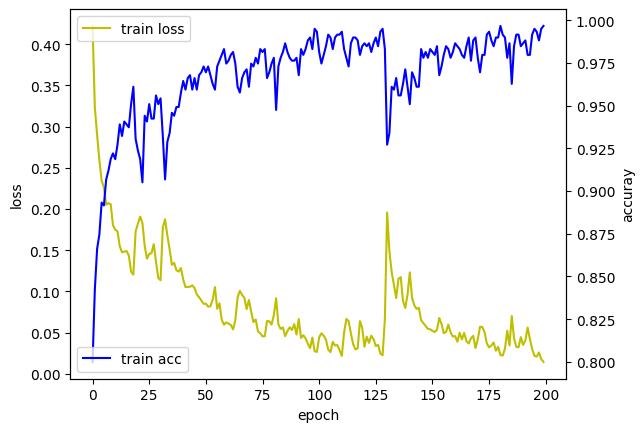

Test AUC:  0.9903381642512077
4/4 - 0s - loss: 0.1841 - accuracy: 0.9487 - auc: 0.9894

Accuracy: 0.9487179517745972
[[46  2]
 [ 4 65]]
46 2 4 65
Neg %: 0.9583333333333334 Pos %: 0.9420289855072463


In [6]:
X = subsample(inputs, min_len)
X_train, X_test, Y_train, Y_test = train_test_split(X, Target, test_size=0.2)  

sm = imblearn.over_sampling.SMOTE()         # random state do not set
origin_shape = np.array(X_train).shape
new_X_train = np.array(X_train).reshape(origin_shape[0], origin_shape[1]*origin_shape[2]*origin_shape[3])
Y_train = np.array(Y_train).astype('float64')
X_train, Y_train = sm.fit_resample(new_X_train, Y_train)
temp = X_train.shape
X_train = X_train.reshape([temp[0], origin_shape[1], origin_shape[2], origin_shape[3]])
Y_train = np.eye(2)[Y_train.reshape(temp[0]).astype('int')]
model = build_model(num_classes=2, input_shape=np.array(X_train[0]).shape)
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', keras.metrics.AUC()])

hist = model.fit(x=np.array(X_train).transpose([0,1,2,3]), y=Y_train, batch_size=None, validation_split=0, epochs=200, 
                 verbose=1, use_multiprocessing=True)
## Train Confusion Matrix

train_predictions = model.predict(np.array(X_train).transpose([0,1,2,3]))

flatten_Y_train = []
flatten_train_predictions = []

for i in range(len(Y_train)):
    if Y_train[i][0] == 1:
        flatten_Y_train.append(0)
    else:
        flatten_Y_train.append(1)
        

for i in range(len(train_predictions)):
    if train_predictions.round()[i][0] == 1:
        flatten_train_predictions.append(0)
    else:
        flatten_train_predictions.append(1)


conf_mat = confusion_matrix(flatten_Y_train, flatten_train_predictions)
print(conf_mat)

tn, fp, fn, tp = conf_mat.ravel()
print(tn, fp, fn, tp)
print('Neg %:', tn/(tn+fp), 'Pos %:', tp/(tp+fn))
# Display acc, loss

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
predictions = model.predict(np.array(X_test).transpose([0,1,2,3]))


Y_test = np.eye(2)[Y_test]
auc = roc_auc_score(Y_test, predictions)
print('Test AUC: ', auc)
frequency = np.zeros(len(Y_test[0]))

for i in range(len(predictions)):
    frequency[np.argmax(predictions[i])] +=1

frequency
test_loss, test_acc, test_auc = model.evaluate(np.array(X_test).transpose([0,1,2,3]),  np.array(Y_test).transpose([0,1]), verbose=2)
print('\nAccuracy:', test_acc)
## Test Confusion Matrix

flatten_Y_test = []
flatten_predictions = []

for i in range(len(Y_test)):
    if Y_test[i][0] == 1:
        flatten_Y_test.append(0)
    else:
        flatten_Y_test.append(1)


for i in range(len(predictions)):
    if predictions.round()[i][0] == 1:
        flatten_predictions.append(0)
    else:
        flatten_predictions.append(1)
        

conf_mat = confusion_matrix(flatten_Y_test, flatten_predictions)
print(conf_mat)

tn, fp, fn, tp = conf_mat.ravel()
print(tn, fp, fn, tp)
print('Neg %:', tn/(tn+fp), 'Pos %:', tp/(tp+fn))